# [VAE in Pyro](http://pyro.ai/examples/vae.html#VAE-in-Pyro)

Let’s see how we implement a VAE in Pyro. The dataset we’re going to model is MNIST, a collection of images of handwritten digits. Since this is a popular benchmark dataset, we can make use of PyTorch’s convenient data loader functionalities to reduce the amount of boilerplate code we need to write:

In [13]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader

In [14]:
import pyro
import pyro.distributions as dist
import torch

In [15]:
import os

In [16]:
pixel_path = os.path.join(os.environ['HOME']+'/mnist/')

In [17]:
if not os.path.exists(pixel_path):
    os.mkdir(pixel_path)

In [18]:
train_set = MNIST(root=pixel_path, train=True, transform=transforms.ToTensor(), download=False)
test_set = MNIST(root=pixel_path, train=False, transform=transforms.ToTensor())

The main thing to draw attention to here is that we use transforms.ToTensor() to normalize the pixel intensities to the range [0, 1].

In [19]:
use_cuda = False
kwargs = {'num_workers': 1, 'pin_memory': use_cuda}

In [20]:
train_dl = DataLoader(dataset=train_set, batch_size=128, shuffle=True)
test_dl = DataLoader(dataset=test_set, batch_size=128, shuffle=True, **kwargs)

In [63]:
x11 = train_set[11][0]

In [64]:
x11.shape

torch.Size([1, 28, 28])

In [74]:
x11.reshape(-1)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [67]:
import matplotlib.pyplot as plt

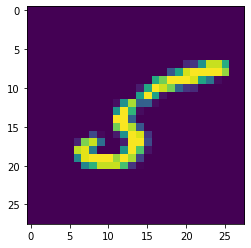

In [69]:
plt.imshow(x11[0])

In [71]:
x11.reshape(-1).shape

torch.Size([784])

___

## VAE

In [21]:
import torch.nn as nn

In [22]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, out_dim) -> None:
        super().__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        hidden = self.softplus(self.fc1(z))
        loc_img = self.sigmoid(self.fc2(hidden))
        return loc_img

In [23]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)

        self.softplus = nn.Softplus()

    def forward(self, x):
        x = x.reshape(-1, self.input_dim)
        hidden = self.softplus(self.fc1(x))
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [24]:
encoder = Encoder(784, 400, 50)
decoder = Decoder(50, 400, 784)

Given an image  the forward call of Encoder returns a mean and covariance that together parameterize a (diagonal) Gaussian distribution in latent space.

In [35]:
class VAE(nn.Module):
    def __init__(self, input_dim = 784, hidden_dim = 400, z_dim = 50, out_dim = 784, use_cuda = False) -> None:
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, z_dim)
        self.decoder = Decoder(z_dim, hidden_dim, out_dim)

        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.input_dim = input_dim

    def model(self, x):
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            #p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            #we use new_zeros and new_ones to ensure that newly created tensors are on the same GPU device.
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample code from prior
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # use of .to_event(1) when sampling from the latent z - this ensures that instead of 
            # treating our sample as being generated from a univariate normal with batch_size = z_dim, 
            # we treat them as being generated from a multivariate normal distribution with diagonal covariance. 
            # As such, the log probabilities along each dimension is summed out when we evaluate .log_prob for 
            # a “latent” sample.
            loc_img = self.decoder(z)
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, self.input_dim)) 

    
    def guide(self, x):
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder(x)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))



    def reconstruct(self, x):
        z_loc, z_scale = self.encoder(x)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder(z)
        return loc_img


The point we’d like to make here is that the two Modules encoder and decoder are attributes of VAE (which itself inherits from nn.Module). This has the consequence they are both automatically registered as belonging to the VAE module. So, for example, when we call parameters() on an instance of VAE, PyTorch will know to return all the relevant parameters. It also means that if we’re running on a GPU, the call to cuda() will move all the parameters of all the (sub)modules into GPU memory.

___

In [36]:
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

In [37]:
LR = 1.0e-3
USE_CUDA = False
NUM_EPOCKS = 1
TEST_FREQUENCY = 5

In [38]:
pyro.clear_param_store()

In [39]:
vae = VAE(use_cuda=USE_CUDA)

In [40]:
adam_args = {"lr": LR}
optimizer = Adam(adam_args)

In [41]:
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

In [73]:
svi.step(x11)
    

ValueError: Error while computing log_prob at site 'obs':
Expected value argument (Tensor of shape (1, 784)) to be within the support (Boolean()) of the distribution Bernoulli(probs: torch.Size([1, 784])), but found invalid values:
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.1216, 0.1569, 0.5059, 0.9176, 0.9176, 0.6235, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2667,
         0.5882, 0.9373, 0.9961, 0.9922, 0.9922, 0.9922, 0.8431, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6118, 0.7882,
         0.9961, 0.9961, 0.9961, 0.9451, 0.5882, 0.3843, 0.0314, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0745, 0.6039, 0.9961,
         0.9255, 0.7961, 0.3255, 0.1529, 0.1176, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5647, 0.9922,
         0.5686, 0.0471, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0392, 0.5059, 0.8706, 0.3059,
         0.3098, 0.0314, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5255, 0.9922, 0.6549,
         0.0314, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.9961,
         0.3059, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7882,
         0.9922, 0.8863, 0.2706, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2157, 0.0235, 0.0000,
         0.0706, 0.5020, 0.9922, 0.9451, 0.1608, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0980, 0.8039, 0.9216, 0.3608,
         0.0000, 0.0000, 0.0784, 0.9922, 0.9922, 0.2275, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9059, 0.9608, 0.4235,
         0.0000, 0.0000, 0.0000, 0.5176, 0.9922, 0.7255, 0.0549, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4745, 0.9608,
         0.9961, 0.9961, 0.9961, 0.8510, 0.9961, 0.8745, 0.1961, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.4549, 0.6471, 0.9137, 0.9137, 0.9176, 0.7059, 0.1529, 0.0118, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]])
       Trace Shapes:            
        Param Sites:            
decoder$$$fc1.weight 400  50    
  decoder$$$fc1.bias     400    
decoder$$$fc2.weight 784 400    
  decoder$$$fc2.bias     784    
       Sample Sites:            
         latent dist   1   |  50
               value   1   |  50
            log_prob   1   |    
            obs dist   1   | 784
               value   1   | 784

In [72]:
z_loc = x.new_zeros(torch.Size((128,50)))
            #we use new_zeros and new_ones to ensure that newly created tensors are on the same GPU device.
z_scale = x.new_ones(torch.Size((128, 50)))
z = pyro.sample("latent", dist.Normal(z_loc, z_scale))
img = vae.decoder(z)
pyro.sample("data", dist.Bernoulli(img)).shape

torch.Size([128, 784])